In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.base import clone
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
%matplotlib inline
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
import time

# Data Processing

### Open Data


In [4]:
data = pd.read_csv('./dataset/train.csv')
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


## Describe

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Data from 2000 mobile phones make up this dataset, which has 21 variables total—20 independent and 1 dependent (price_range). The dataset includes 8 categorical variables (n_cores, price_range, blue, dual_sim, four_g, three_g, touch_screen, wifi) and 13 numeric variables (battery_power, clock_speed, fc, int_memory, m_dep, mobile_wt, pc, px_height, px_width, ram, talk_time, sc_h, sc_w).

In [6]:
# Check for missing and duplicated values
print(data.isnull().sum())
print(data.duplicated().sum())

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64
0


- This dataset contains information from 2000 mobile phones.
 - We have 21 variables including 20 independent variables and 1 dependent variable which is price_range.
- There is no missing value in the dataset.
- We have 8 categorical variables: n_cores , price_range, blue, dual_sim, four_g, three_g, touch_screen, wifi
- We have 13 numeric variables: battery_power, clock_speed, fc, int_memory, m_dep, mobile_wt, pc, px_height, px_width, ram, talk_time, sc_h, sc_w


### Statistical Description of Categorical Variables

In [7]:
# Filter out categorical features
data_categorical = data[['price_range', 'n_cores', 'blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']].astype(str)

# Calculate number of unique values and unique values for each feature
unique_counts = data_categorical.nunique()
unique_values = data_categorical.apply(lambda x: x.unique())

# Create new dataframe with the results
pd.DataFrame({'Number of Unique Values': unique_counts, 'Unique Values': unique_values})

,Number of Unique Values,Unique Values
price_range,4,"[1, 2, 3, 0]"
n_cores,8,"[2, 3, 5, 6, 1, 8, 4, 7]"
blue,2,"[0, 1]"
dual_sim,2,"[0, 1]"
four_g,2,"[0, 1]"
three_g,2,"[0, 1]"
touch_screen,2,"[0, 1]"
wifi,2,"[1, 0]"


### Statistical Description of Numerical Variables

In [8]:
# Filter out numerical features
data_numerical = data.drop(data_categorical.columns, axis=1)
# Generate descriptive statistics
data_numerical.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.5,439.4,501.0,851.8,1226.0,1615.2,1998.0
clock_speed,2000.0,1.5,0.8,0.5,0.7,1.5,2.2,3.0
fc,2000.0,4.3,4.3,0.0,1.0,3.0,7.0,19.0
int_memory,2000.0,32.0,18.1,2.0,16.0,32.0,48.0,64.0
m_dep,2000.0,0.5,0.3,0.1,0.2,0.5,0.8,1.0
mobile_wt,2000.0,140.2,35.4,80.0,109.0,141.0,170.0,200.0
pc,2000.0,9.9,6.1,0.0,5.0,10.0,15.0,20.0
px_height,2000.0,645.1,443.8,0.0,282.8,564.0,947.2,1960.0
px_width,2000.0,1251.5,432.2,500.0,874.8,1247.0,1633.0,1998.0
ram,2000.0,2124.2,1084.7,256.0,1207.5,2146.5,3064.5,3998.0


## Visualization

(2000, 21)

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64

<Axes: xlabel='price_range', ylabel='count'>

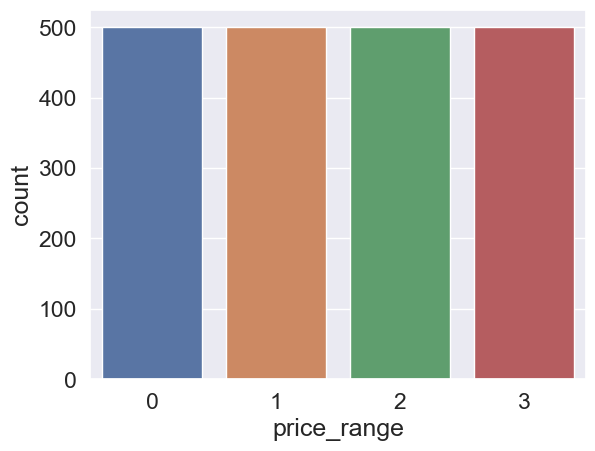

In [ ]:
display(data.shape)
display(data["price_range"].value_counts())
sns.countplot(x='price_range', data=data)

### Categorical Variables

In [9]:
# Create the subplots
fig = make_subplots(rows=3, cols=3, specs=[[{'type':'domain'}]*3]*3, vertical_spacing=0.05, horizontal_spacing=0.01)

# Loop through all the features and add the pie chart to the subplot
for i, feature in enumerate(data_categorical.columns):
    value_counts = data_categorical[feature].value_counts()
    labels = value_counts.index.tolist()
    values = value_counts.values.tolist()

    # Define color map based on orangered color
    cmap = colors.LinearSegmentedColormap.from_list('blue', ['#ADD8E6', 'blue'])
    norm = colors.Normalize(vmin=0, vmax=len(labels))
    color_list = [colors.rgb2hex(cmap(norm(i))) for i in range(len(labels))]

   # Create the pie chart
    pie_chart = go.Pie(
        labels=labels,
        values=values,
        hole=0.6,
        marker=dict(colors=color_list, line=dict(color='white', width=3)),
        textposition='inside',
        textinfo='percent+label',
        title=feature,  # Add title with the feature name
        title_font=dict(size=25, color='black', family='Calibri')
    )

    # Add the pie chart to the subplot
    if i < 8:
        row = i // 3 + 1
        col = i % 3 + 1
        fig.add_trace(pie_chart, row=row, col=col)

# Update the layout
fig.update_layout(showlegend=False, height=1000, width=980,
                   title={
                          'text':"Distribution of Categorical Variables",
                          'y':0.95,
                          'x':0.5,
                          'xanchor':'center',
                          'yanchor':'top',
                          'font': {'size':28, 'color':'black', 'family':'Calibri'}
                         })

# Show the plot
fig.show()

The mobile phones are evenly distributed across the four price_range classes, making the dataset completely balanced. Additionally, the frequencies of mobile phones with or without Bluetooth, 4G, touch screens, Wifi, dual SIM support, and varying numbers of processing cores are almost identical. Approximately 76% of the mobile phones support 3G.

### Numerical Variables

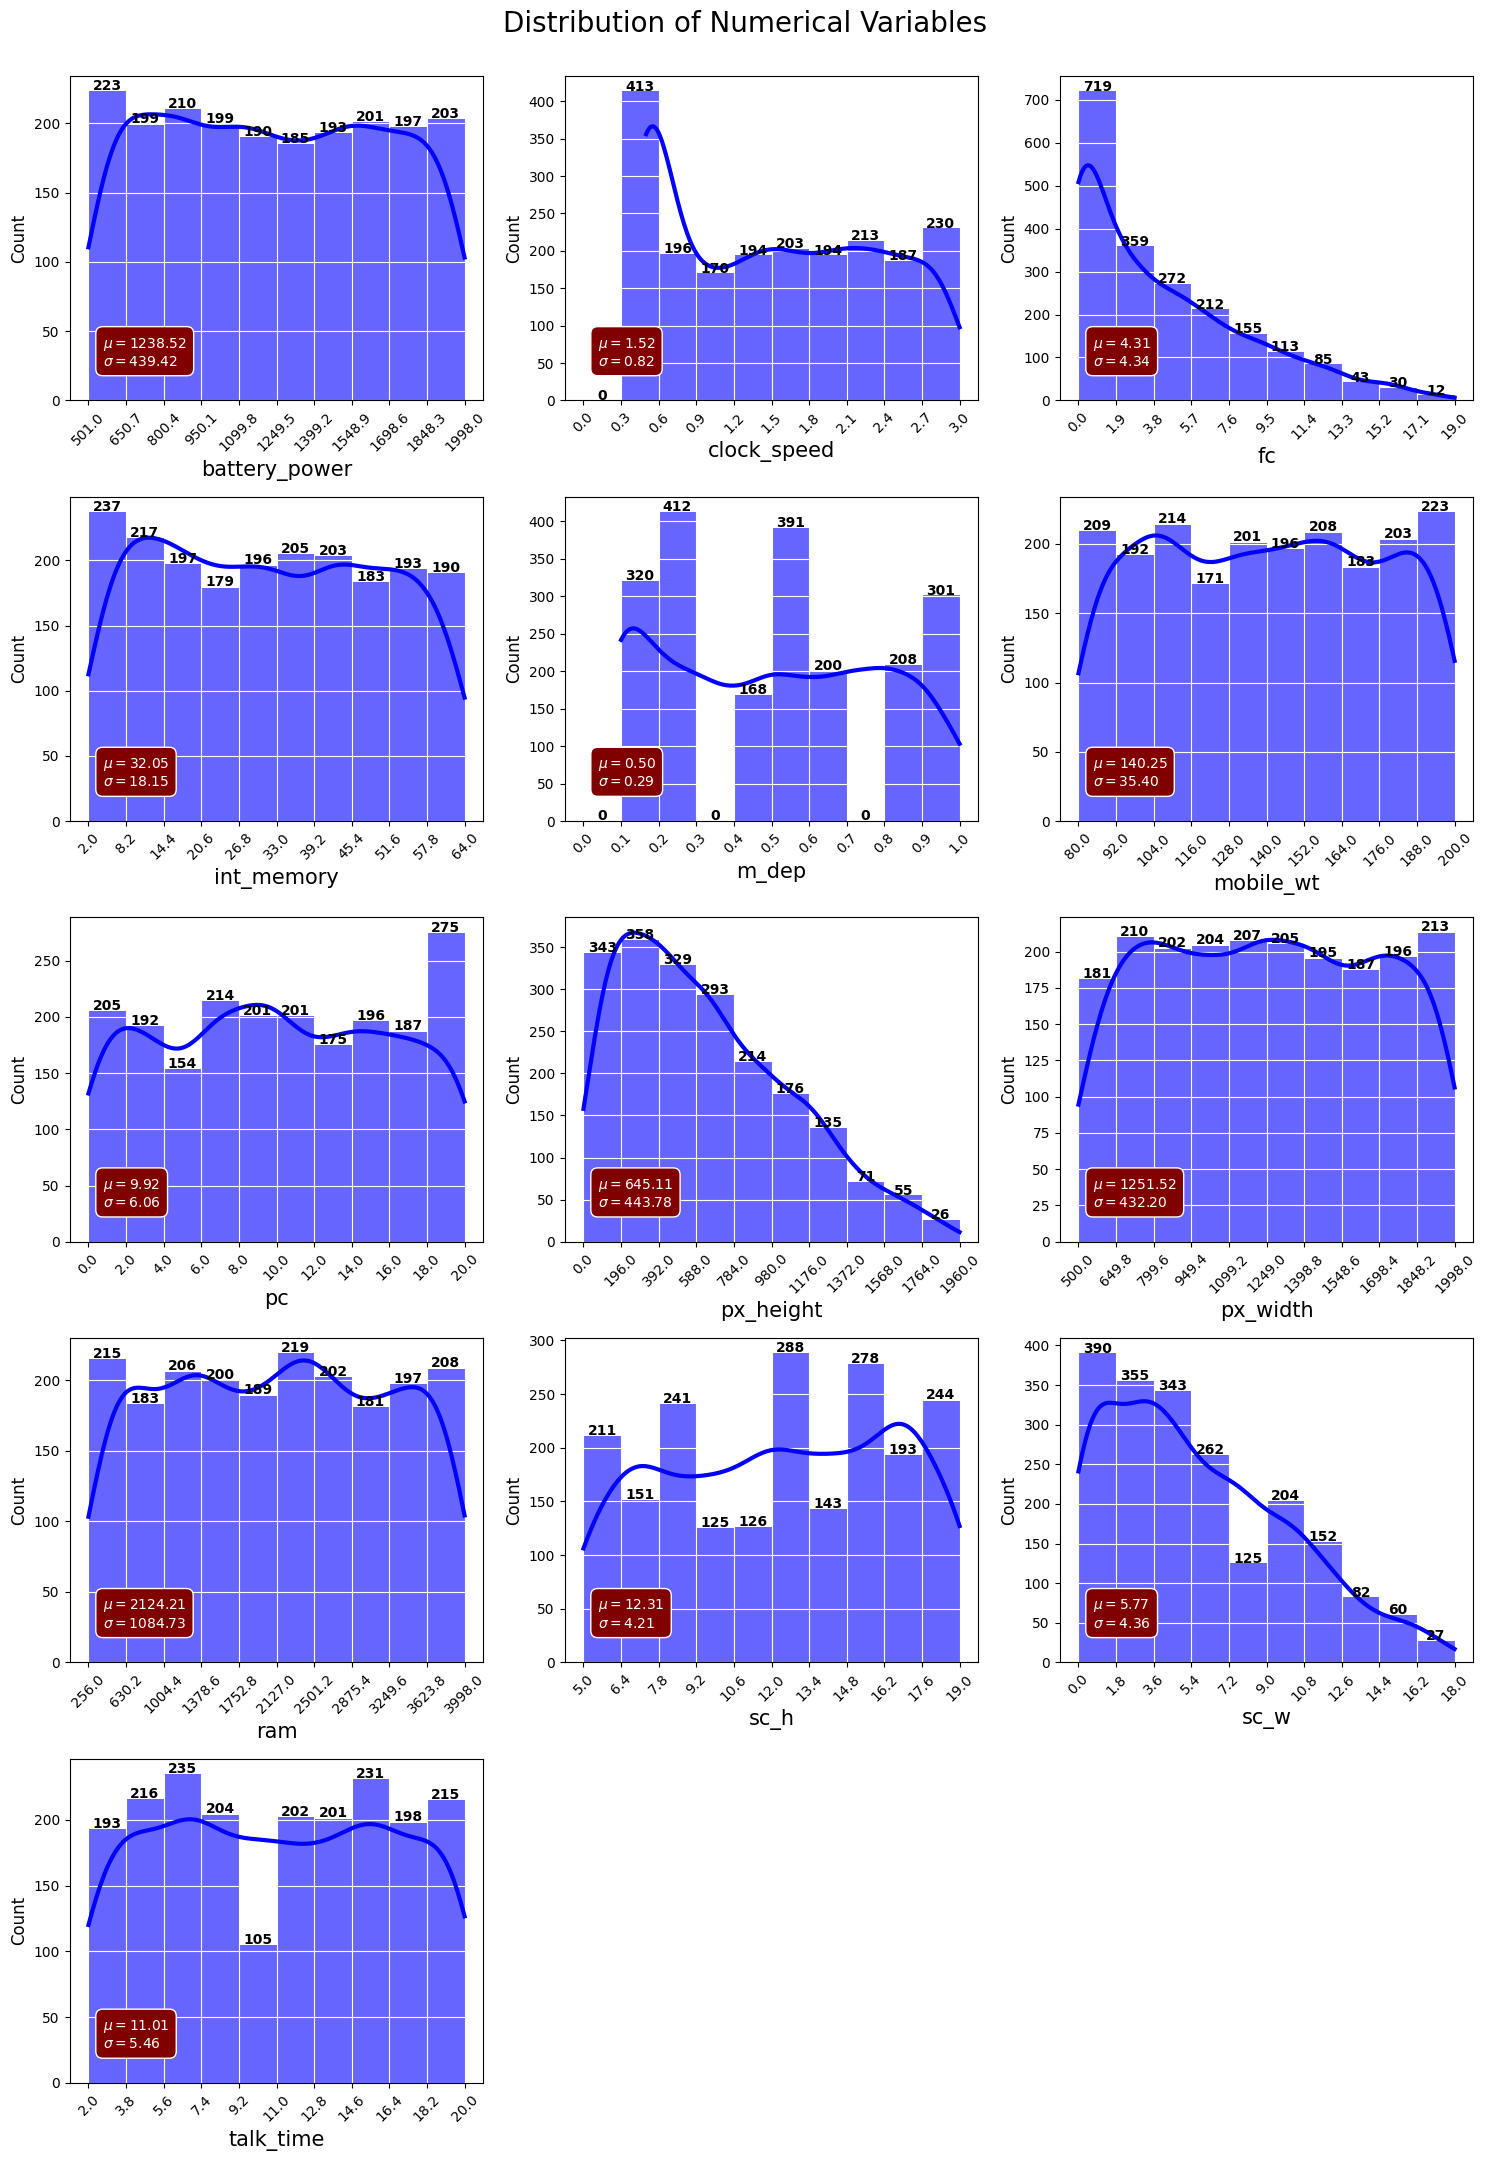

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15,22)) #, dpi=200
colorMap = 'blue'

for i, col in enumerate(data_numerical.columns):
    x = i//3
    y = i%3
    values, bin_edges = np.histogram(data_numerical[col],
                                     range=(np.floor(data_numerical[col].min()), np.ceil(data_numerical[col].max())))
    graph = sns.histplot(data=data_numerical, x=col, bins=bin_edges, kde=True, ax=ax[x,y],
                         edgecolor='none', color=colorMap, alpha=0.6, line_kws={'lw': 3})
    ax[x,y].set_xlabel(col, fontsize=15)
    ax[x,y].set_ylabel('Count', fontsize=12)
    ax[x,y].set_xticks(np.round(bin_edges,1))
    ax[x,y].set_xticklabels(ax[x,y].get_xticks(), rotation = 45)
    ax[x,y].grid(color='white')
    for j,p in enumerate(graph.patches):
        ax[x,y].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")
    textstr = '\n'.join((
    r'$\mu=%.2f$' %data_numerical[col].mean(),
    r'$\sigma=%.2f$' %data_numerical[col].std()
    ))
    ax[x,y].text(0.08, 0.2, textstr, transform=ax[x,y].transAxes, fontsize=10, verticalalignment='top',
                color='white', bbox=dict(boxstyle='round',facecolor='maroon', edgecolor='white', pad=0.5))

ax[4, 1].axis('off')
ax[4, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

By examining the graphs above, we can easily discern the statistical values of each feature, such as the minimum, maximum, average, and standard deviation. Some features, like px_height (Pixel Resolution Height) and sc_w (Screen Width of mobile in cm), exhibit numerous values close to zero, which appear to be noise.

### Pearson Correlation

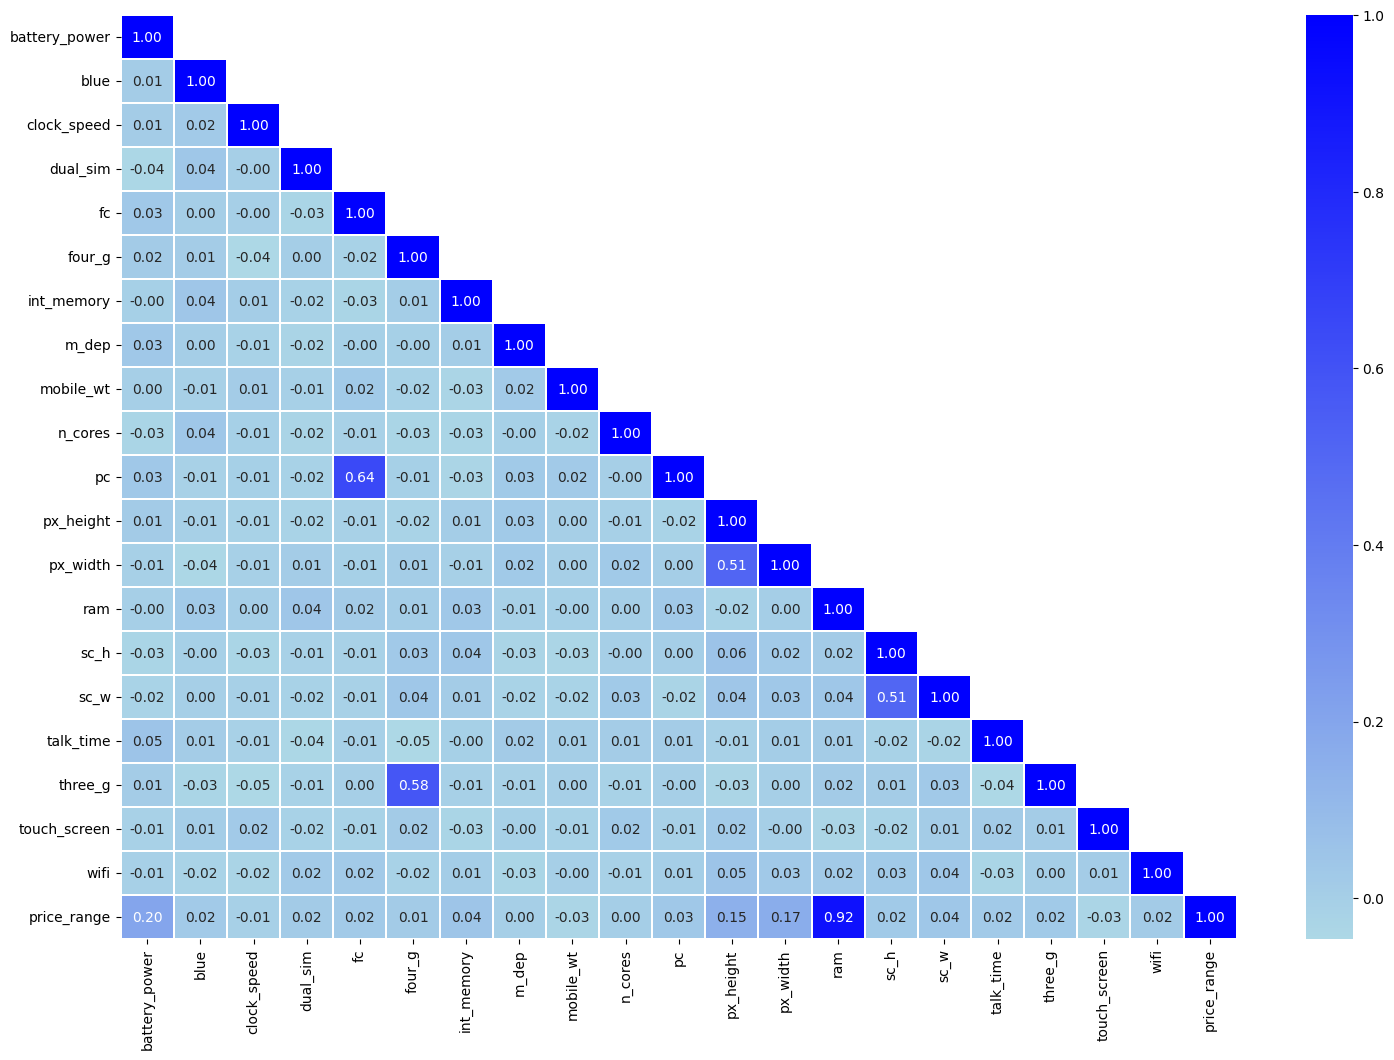

In [11]:
# Define a colormap
blue_cmap = LinearSegmentedColormap.from_list('blue', ['#ADD8E6', 'blue'])

# Calculation of the Spearman correlation
target = 'price_range'
df_ordered = pd.concat([data.drop(target,axis=1), data[target]],axis=1)
corr = df_ordered.corr()

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(18,12))
sns.heatmap(corr, mask=mask, annot=True, cmap=blue_cmap, fmt='.2f', linewidths=0.2)
plt.show()

### Noise Dectection
    As seen px_height (Pixel Resolution Height) and sc_w (Screen Width of mobile in cm) contain many values of zero and close to zero, which look like noise

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



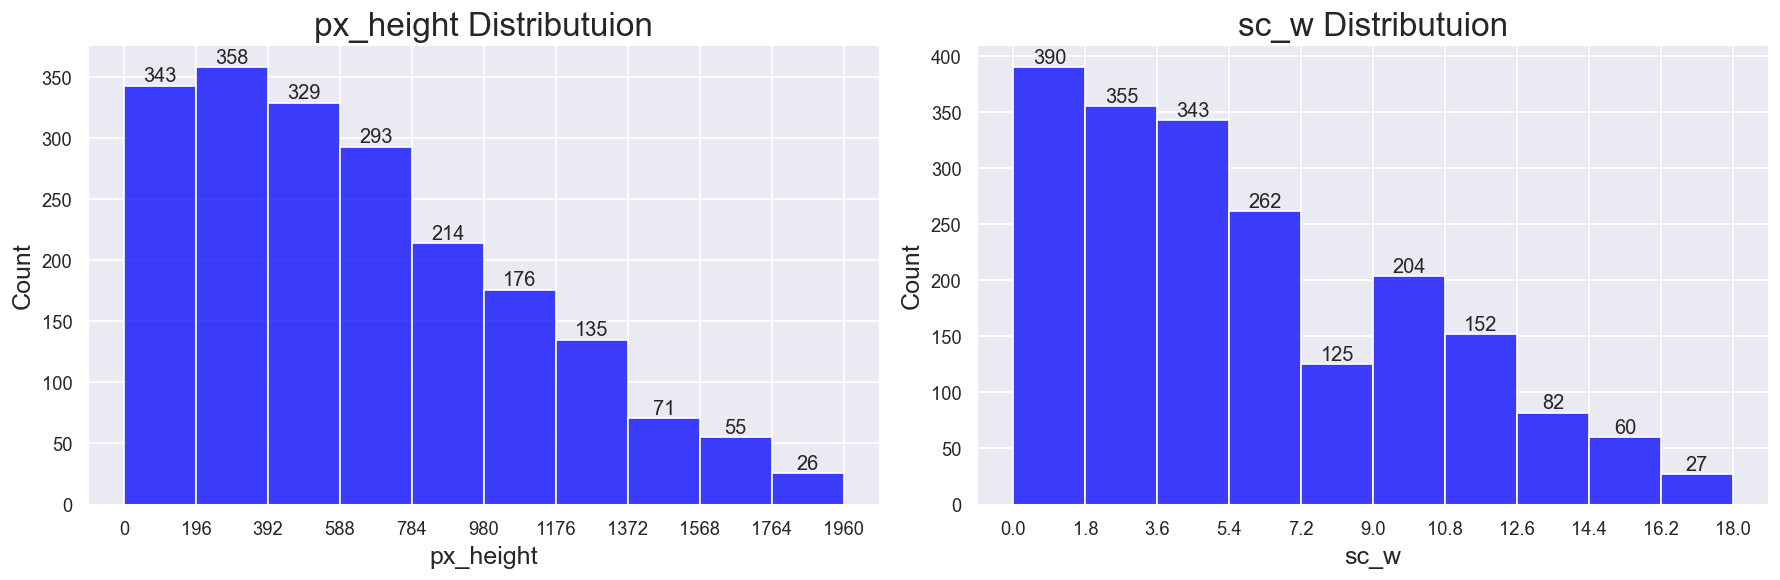

In [ ]:
def show_noise (data):
    sns.set(rc = {'axes.labelsize' : 15})
    fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)


    # Plot px_height histogram:
    _, bin_edges = np.histogram(data['px_height'], range=(np.floor(data['px_height'].min()), np.ceil(data['px_height'].max())))
    graph1 = sns.histplot(x='px_height', data=data, bins=bin_edges, color='blue', ax=ax[0])
    ax[0].set_xticks(bin_edges)
    ax[0].set_title('px_height Distributuion', fontsize=20)
    for cont in graph1.containers:
            graph1.bar_label(cont)

    # Plot sc_w histogram:
    _, bin_edges = np.histogram(data['sc_w'], range=(np.floor(data['sc_w'].min()), np.ceil(data['sc_w'].max())))
    graph2 = sns.histplot(x='sc_w', data=data, bins=bin_edges, color='blue', ax=ax[1])
    ax[1].set_xticks(bin_edges)
    ax[1].set_title('sc_w Distributuion', fontsize=20)
    for cont in graph2.containers:
            graph2.bar_label(cont)

    plt.tight_layout()
    plt.show()
show_noise(data)

In [ ]:
# Detect Noise values in sc_w
sc_w_NoiseIndex = data[data['sc_w'] < 2].index

# Detect Noise values in px_height
px_height_NoiseIndex = data[data['px_height'] < 5].index

print('The number of detected noise values for sc_w: ', len(sc_w_NoiseIndex))
print('The number of detected noise values for px_height: ', len(px_height_NoiseIndex))

The number of detected noise values for sc_w:  390
The number of detected noise values for px_height:  9


## Pre-processing

### Define Functions for using later

### Define a function that finds the optimal combination of hyperparameters to achieve the best accuracy for our classifier. The function uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters, and selects the combination with the highest accuracy

In [ ]:
def tune_hyperparameters(clf, param_grid, X_train, y_train):
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    # GridSearVC with cross-validation (5 folds)
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, return_train_score=True)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Extract all accuracy scores and their corresponding hyperparameters
#    results = clf_grid.cv_results_
    all_accuracies = clf_grid.cv_results_['mean_test_score']
    all_params = clf_grid.cv_results_['params']

    # Combination
    accuracies_with_params = [{'params': params, 'accuracy': accuracy} for params, accuracy in zip(all_params, all_accuracies)]

    # Print all accuracy scores with their corresponding hyperparameters
    for item in accuracies_with_params:
        print(f"Hyperparameters: {item['params']}, Accuracy: {item['accuracy']:.4f}")

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)

    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

### Define Drop-column Feature Importances

In [ ]:
def drop_column_importance(model, X_train, y_train, random_state=0):
    # Important features list
    importances = []
    # Clone the model
    cloned_classifier = clone(model)
    # Set random_state for comparability
    cloned_classifier.random_state = random_state
    # Train the model
    cloned_classifier.fit(X_train, y_train)
    # Create the cross-validation object using StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Score the benchmark model using cross-validation
    original_score = cross_val_score(cloned_classifier, X_train, y_train, cv=cv, scoring='accuracy').mean()


    # Iterate over all features and store feature importance
    for col in X_train.columns:
        # Clone the model
        cloned_classifier = clone(model)
        # Set random_state for comparability
        cloned_classifier.random_state = random_state
        # Traint the model on the the dataset with a single feature removed
        cloned_classifier.fit(X_train.drop(col, axis = 1), y_train)
        # Score the droped-column model
        drop_column_score = cross_val_score(cloned_classifier, X_train.drop(col,axis=1), y_train, cv=cv, scoring='accuracy').mean()
        # Store feature importance which is defined as the difference between the benchmark and the new model score
        importances.append(original_score - drop_column_score)

    # Return the features along with their importances in the form of a dataframe
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending = False).reset_index(drop = True)

    return importances_df

### Define a function to visualize the results of Drop-column Feature Importance technique using bar charts:

In [ ]:
def drop_column_importance_plot(model, X_train, y_train):

    # Call drop-column feature importance function
    df_drop_column = drop_column_importance(model, X_train, y_train, random_state=0)
    # Rename columns
    df_drop_column.columns = ['Feature', 'Feature Importance']

    # Plot barchart
    plt.figure(figsize=(12,10))
    sns.barplot(data=df_drop_column, x='Feature Importance', y='Feature', orient='h', color='orangered')
    plt.title('Drop Column Feature Importance', fontsize=20)
    plt.show()

### Handle Noise values ( KNN imputer)

KNN Imputer:
KNN Imputer is a machine learning technique used to impute or fill in missing values and noise values in a dataset. The technique works by finding the k-nearest neighbors of a data point with missing values and then imputing the missing values with the average of those neighbors.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



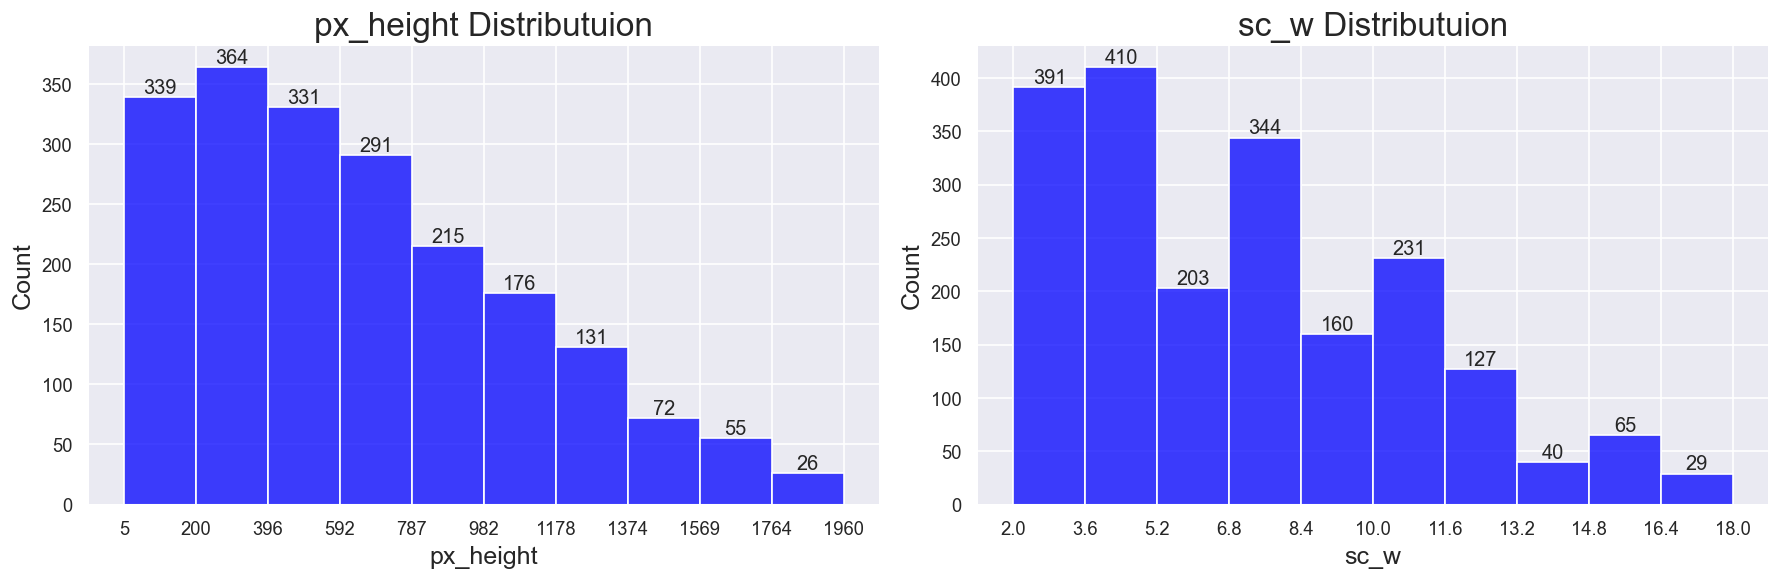

In [ ]:
# Make a copy of dataset
data_denoised = data.copy()

# Replace the noise values with NaN
data_denoised.loc[sc_w_NoiseIndex,'sc_w'] = np.nan
data_denoised.loc[px_height_NoiseIndex,'px_height'] = np.nan

# Create a KNN imputer object with k=2
imputer = KNNImputer(n_neighbors=2)

# Impute the noise values
imputed_data = imputer.fit_transform(data_denoised)

# Convert array to dataframe
data_denoised = pd.DataFrame(imputed_data, columns=data_denoised.columns)

# Define the features (X) and the output labels (y)
X_denoised = data_denoised.drop('price_range', axis=1)
data_denoised['price_range'] = data_denoised['price_range'].astype(int)
y_denoised = data_denoised['price_range']

show_noise(data_denoised)

### Split Data

In [ ]:
#  Define the features (X) and the output labels (y) of the given dataset:
X = data.drop('price_range', axis=1)
y = data['price_range']

# Perform train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train.head()
y_train.head()

538     2
1094    0
1654    0
8       0
1256    3
Name: price_range, dtype: int64

### Scale Data using Standard Scaler

In [ ]:
# Scale the training and test data using Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# Convert training and test sets from numpy array to pandas dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
# X_train.head()
# X_test.head()
X_test_scaled.head()
X_train_scaled.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,-1.224482,-0.986343,0.864565,0.974086,-0.062153,-1.024039,1.149911,-1.051079,1.290899,0.645472,-0.636457,-0.896344,-0.549698,1.410784,-1.271123,-1.116022,0.731978,0.572539,0.992528,0.982650
1,-1.260995,1.013846,-0.003877,-1.026604,-0.980817,-1.024039,-1.662062,1.730358,-1.436365,-0.654136,-1.302032,-0.851552,-0.882466,-1.591853,-1.743824,-0.886299,-0.549785,0.572539,0.992528,0.982650
2,1.110087,1.013846,0.740502,0.974086,1.315842,-1.024039,1.370458,-0.703399,0.503648,0.645472,1.360270,-0.616393,0.085798,-1.480474,-1.743824,-0.886299,-0.916003,-1.746606,-1.007528,-1.017656
3,0.466540,1.013846,-1.244508,-1.026604,-0.980817,-1.024039,1.149911,0.687319,0.953506,1.078675,0.694695,-0.593996,-0.958726,-0.940147,1.092383,-1.116022,1.647524,0.572539,-1.007528,-1.017656
4,1.155729,-0.986343,-1.244508,-1.026604,-0.062153,-1.024039,-1.055558,0.687319,1.262783,0.645472,0.361907,0.333204,-0.873223,0.906355,-1.271123,-1.116022,-0.183567,0.572539,-1.007528,-1.017656


# Models


## SVC
    1. StandardScaler
    2. Hyperparameter Tunning with GridSearchCV (cross-validation (5 folds))
    3. Train and apply Support Vector Classifier (SVC)

### SVM Hyperparameter Tuning

In [ ]:
# Define the hyperparameter grid to search
param_grid = [
              {'kernel': ['linear'],
               'C': [0.01, 0.1, 1, 10, 100, 1000]}
             ]
# There are considered 6 options

In [ ]:
# Create a SVC object
svm = SVC(probability=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
svm_optimized = tune_hyperparameters(svm, param_grid, X_train_scaled, y_train)

Hyperparameters: {'C': 0.01, 'kernel': 'linear'}, Accuracy: 0.9006
Hyperparameters: {'C': 0.1, 'kernel': 'linear'}, Accuracy: 0.9369
Hyperparameters: {'C': 1, 'kernel': 'linear'}, Accuracy: 0.9587
Hyperparameters: {'C': 10, 'kernel': 'linear'}, Accuracy: 0.9644
Hyperparameters: {'C': 100, 'kernel': 'linear'}, Accuracy: 0.9638
Hyperparameters: {'C': 1000, 'kernel': 'linear'}, Accuracy: 0.9594
Best hyperparameters:
 {'C': 10, 'kernel': 'linear'}


### Implementation

#### Define Evaluation Function

In [ ]:
def metrics_calculator(clf, X_test, y_test, model_name):
    start_time = time.time()
    y_pred = clf.predict(X_test)
    end_time = time.time()
    predict_time = end_time - start_time

    # Create a DataFrame with metrics as strings formatted with percentages
    result = pd.DataFrame(data=[[f"{accuracy_score(y_test, y_pred) * 100:.2f}%",
                                 f"{precision_score(y_test, y_pred, average='macro') * 100:.2f}%",
                                 f"{recall_score(y_test, y_pred, average='macro') * 100:.2f}%",
                                 f"{f1_score(y_test, y_pred, average='macro') * 100:.2f}%",
                                 f"{predict_time:.4f}s"]],
                          columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'Predict time'],
                          index=[model_name])
    return result

In [ ]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    # Set font scale
    sns.set(font_scale=1.5)

    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    start_time = time.time()
    y_pred_test = clf.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, dpi=120, figsize=(15, 7))  # Adjust the layout and size

    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax1.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(1, 4)  # Adjust the scale of the table
    table.set_fontsize(12)
    ax1.axis('tight')
    # Hide the axes
    ax1.axis('off')
    # set the title
    ax1.set_title('{} Performance Summary on Test Data'.format(model_name), fontsize=18)
    # Modify color
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('yellow')

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap='Blues', ax=ax2)
    ax2.set_title('Confusion Matrix for Test Data')
    ax2.grid(False)

    plt.show()
    print(f"Time taken to make predictions: {prediction_time:.2f} seconds")

#### Non-Optimized SVM (without hyperparameter tunning)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.97      0.98      0.98       400
           2       0.97      0.97      0.97       400
           3       0.99      0.98      0.99       400

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       100
           1       0.85      0.85      0.85       100
           2       0.85      0.89      0.87       100
           3       0.96      0.92      0.94       100

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90 

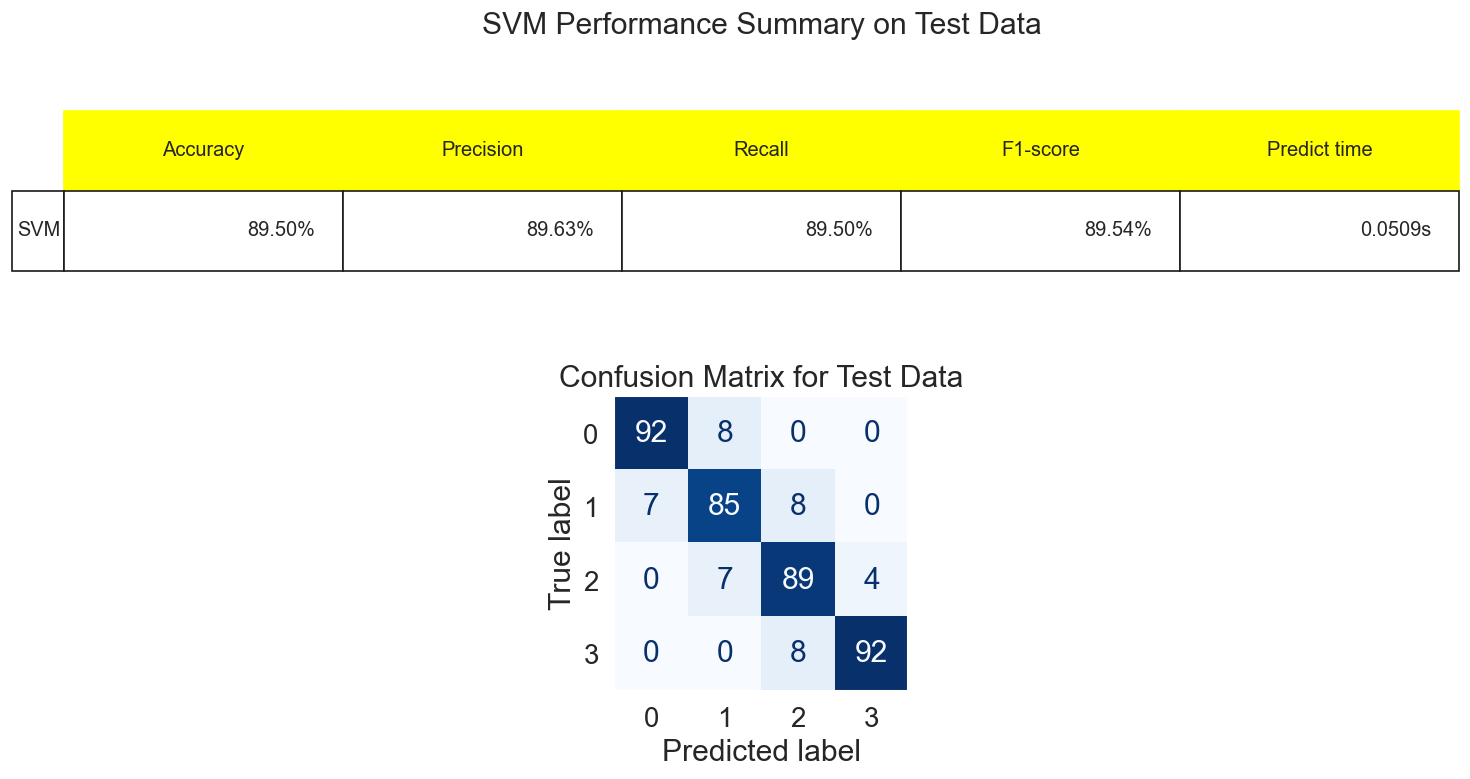

Time taken to make predictions: 0.06 seconds


In [ ]:
svm.fit(X_train_scaled, y_train)
model_evaluation(svm, X_train_scaled, X_test_scaled, y_train, y_test, 'SVM')

#### Optimized SVM


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.97      0.98       400
           2       0.97      0.98      0.97       400
           3       0.99      0.99      0.99       400

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.97      0.95      0.96       100
           2       0.96      0.98      0.97       100
           3       0.99      0.98      0.98       100

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97 

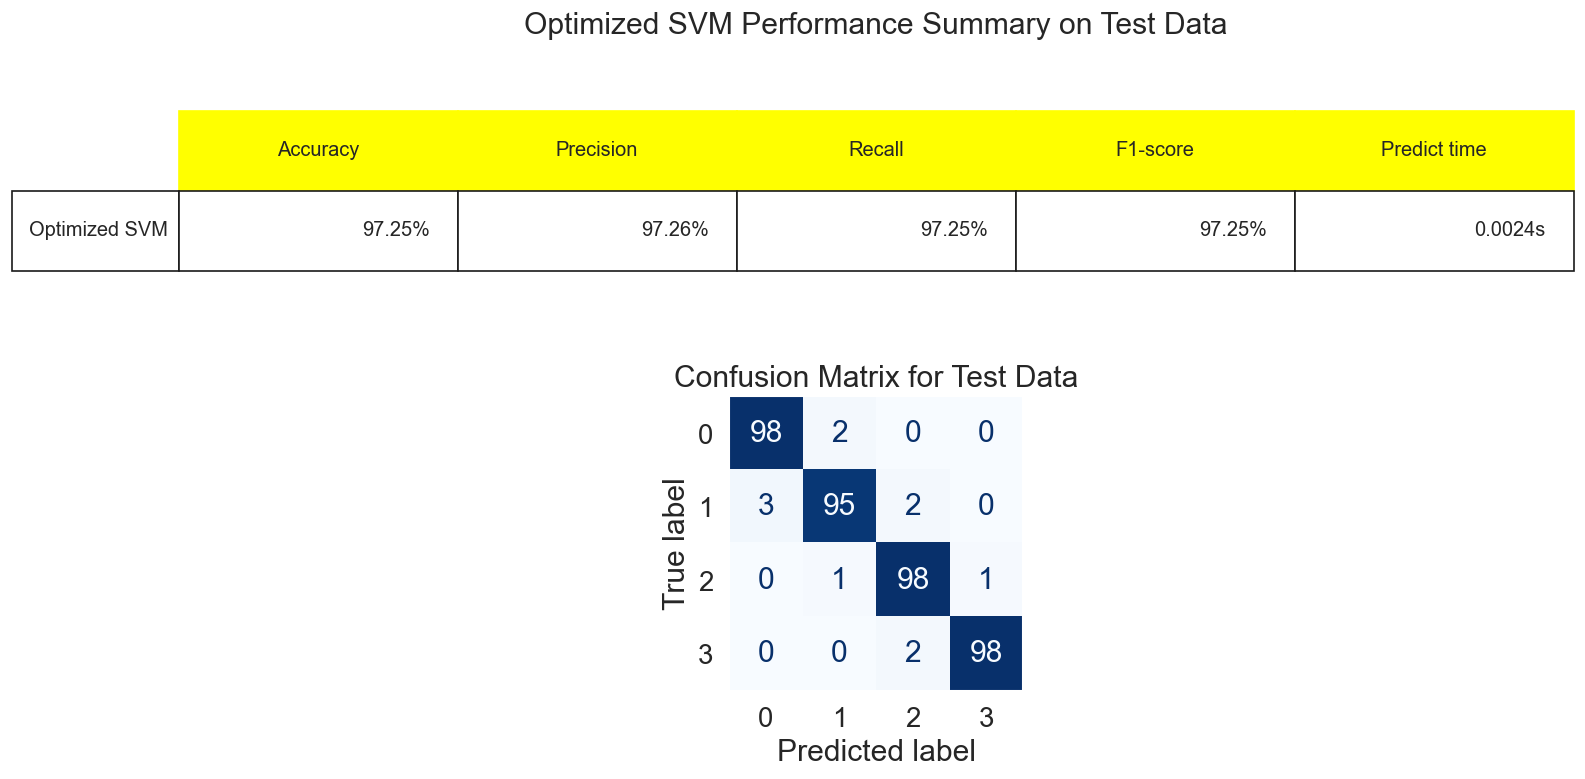

Time taken to make predictions: 0.00 seconds


In [ ]:
svm_optimized.fit(X_train_scaled, y_train)
model_evaluation(svm_optimized, X_train_scaled, X_test_scaled, y_train, y_test, 'Optimized SVM')

In [ ]:
# Save the final performance of SVM classifier
svm_result = metrics_calculator(svm_optimized, X_test_scaled, y_test, 'SVM')

## Decision Tree
    1. Hyperparameter Tuning with GridSearchCV (cross-validation (5 folds))
    2. Drop unnecessary features
    3. Train and apply Decision Tree classifier

#### Hyperparameter Tuning

In [ ]:
# Define the hyperparameter grid
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 15),
              'min_samples_split': np.arange(2, 10),
              'min_samples_leaf': np.arange(1, 10),
              'max_features': [None, 'sqrt', 'log2']}
# split test, train again
X_train_denoised, X_test_denoised, y_train, y_test = train_test_split(X_denoised, y_denoised, test_size=0.2, random_state=0, stratify=y)

# Create a  Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=0)

# Find the best classifier with the optimal hyperparameters
dt_optimized = tune_hyperparameters(dt, param_grid, X_train_denoised, y_train)

Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 7}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8}, Accuracy: 0.4987
Hyperp

#### Drop Unnecessary Columns

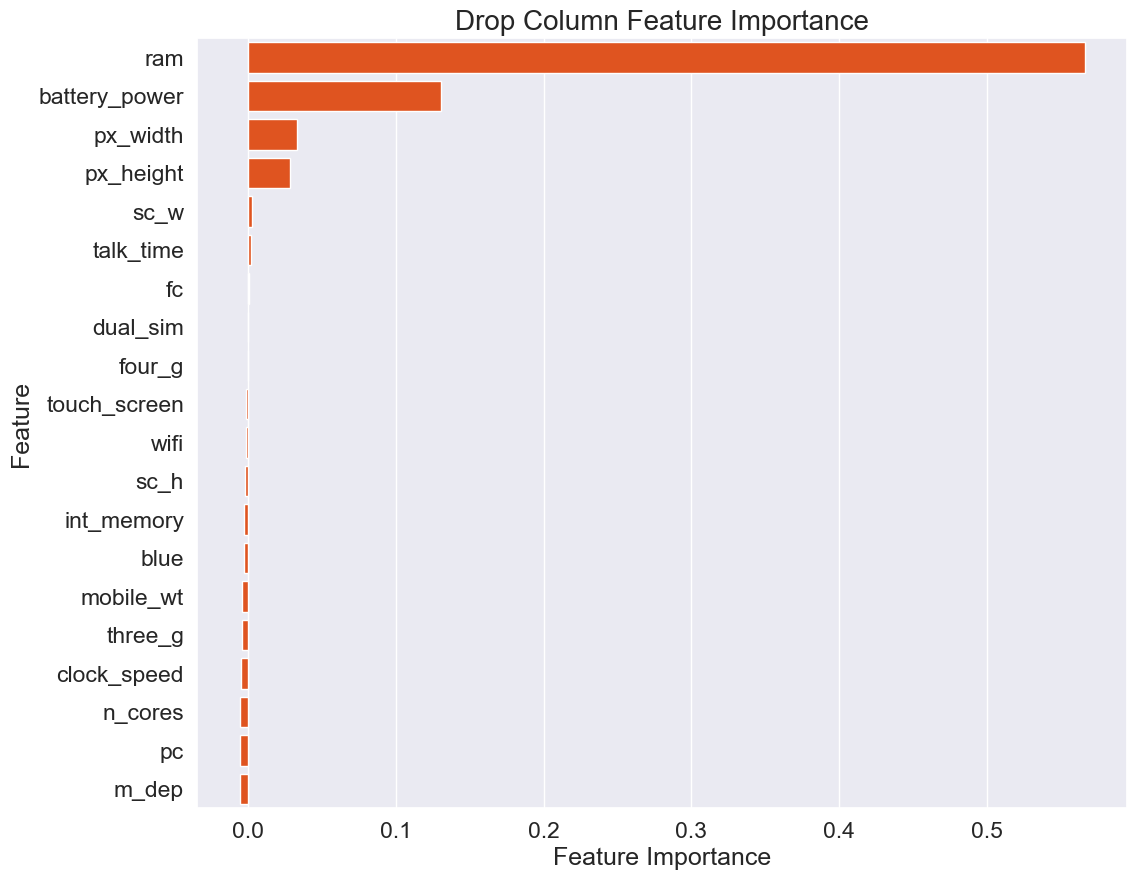

,feature
0,ram
1,battery_power
2,px_width
3,px_height


In [ ]:
drop_column_importance_plot(dt_optimized, X_train, y_train)
# Find Important features with positive feature_importance value
feature_importances = drop_column_importance(dt_optimized, X_train_denoised, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature']  # Threshold value of 0.01

pd.DataFrame(selected_features)

In [ ]:
# Filter dataset
X_train_denoised_droped = X_train_denoised[selected_features]
X_test_denoised_droped = X_test_denoised[selected_features]
display(X_train_denoised_droped)
display(X_test_denoised_droped)



,ram,battery_power,px_width,px_height
538,3653.0,704.0,1013.0,251.0
1094,391.0,688.0,869.0,271.0
1654,512.0,1727.0,1288.0,376.0
8,1099.0,1445.0,836.0,386.0
1256,3105.0,1747.0,873.0,800.0
...,...,...,...,...
1399,1403.0,672.0,1267.0,574.0
1106,398.0,1266.0,1595.0,1187.0
1228,574.0,1820.0,1951.0,1157.0
1478,3011.0,1254.0,1021.0,204.0


,ram,battery_power,px_width,px_height
390,3097.0,1836.0,1139.0,408.0
1702,2658.0,1424.0,1199.0,181.0
1313,3623.0,730.0,846.0,62.0
1707,1181.0,1699.0,1099.0,105.0
1004,3227.0,965.0,653.0,297.0
...,...,...,...,...
205,2243.0,765.0,1429.0,1277.0
417,2244.0,651.0,858.0,548.0
1405,1724.0,1973.0,507.0,127.0
775,595.0,1160.0,859.0,762.0


### Train and apply Decision Tree classifier

##### Non-Optimized Tree classifier


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       100
           1       0.80      0.84      0.82       100
           2       0.77      0.75      0.76       100
           3       0.86      0.86      0.86       100

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84 

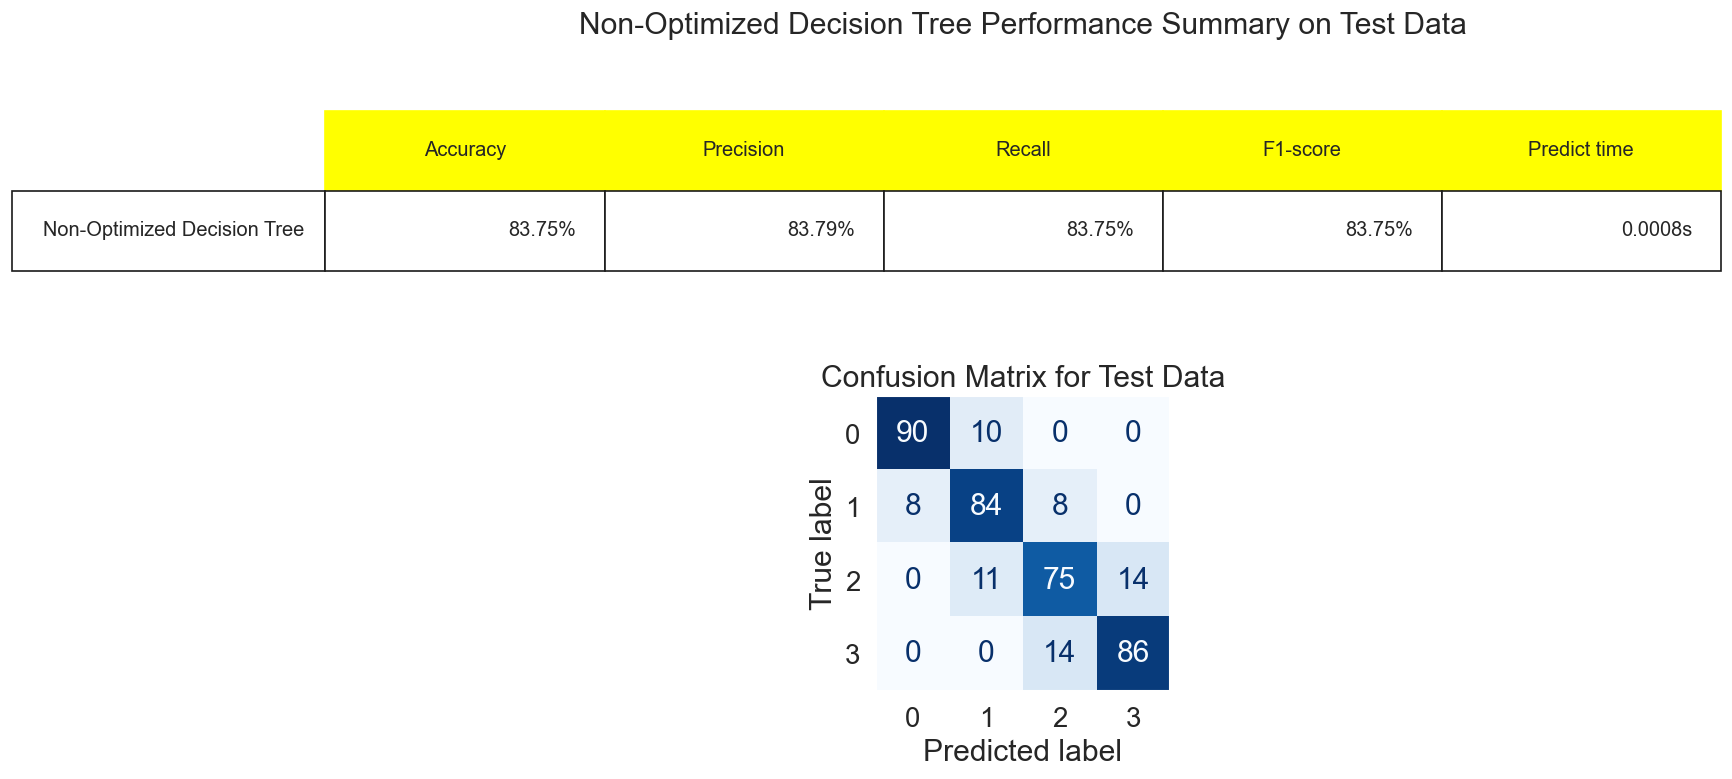

Time taken to make predictions: 0.00 seconds


In [ ]:

dt.fit(X_train, y_train)

model_evaluation(dt, X_train, X_test, y_train, y_test, 'Non-Optimized Decision Tree')

##### Optimzed Tree classifier


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       400
           1       0.96      0.93      0.95       400
           2       0.91      0.97      0.94       400
           3       0.98      0.94      0.96       400

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       100
           1       0.85      0.87      0.86       100
           2       0.82      0.85      0.83       100
           3       0.92      0.86      0.89       100

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88 

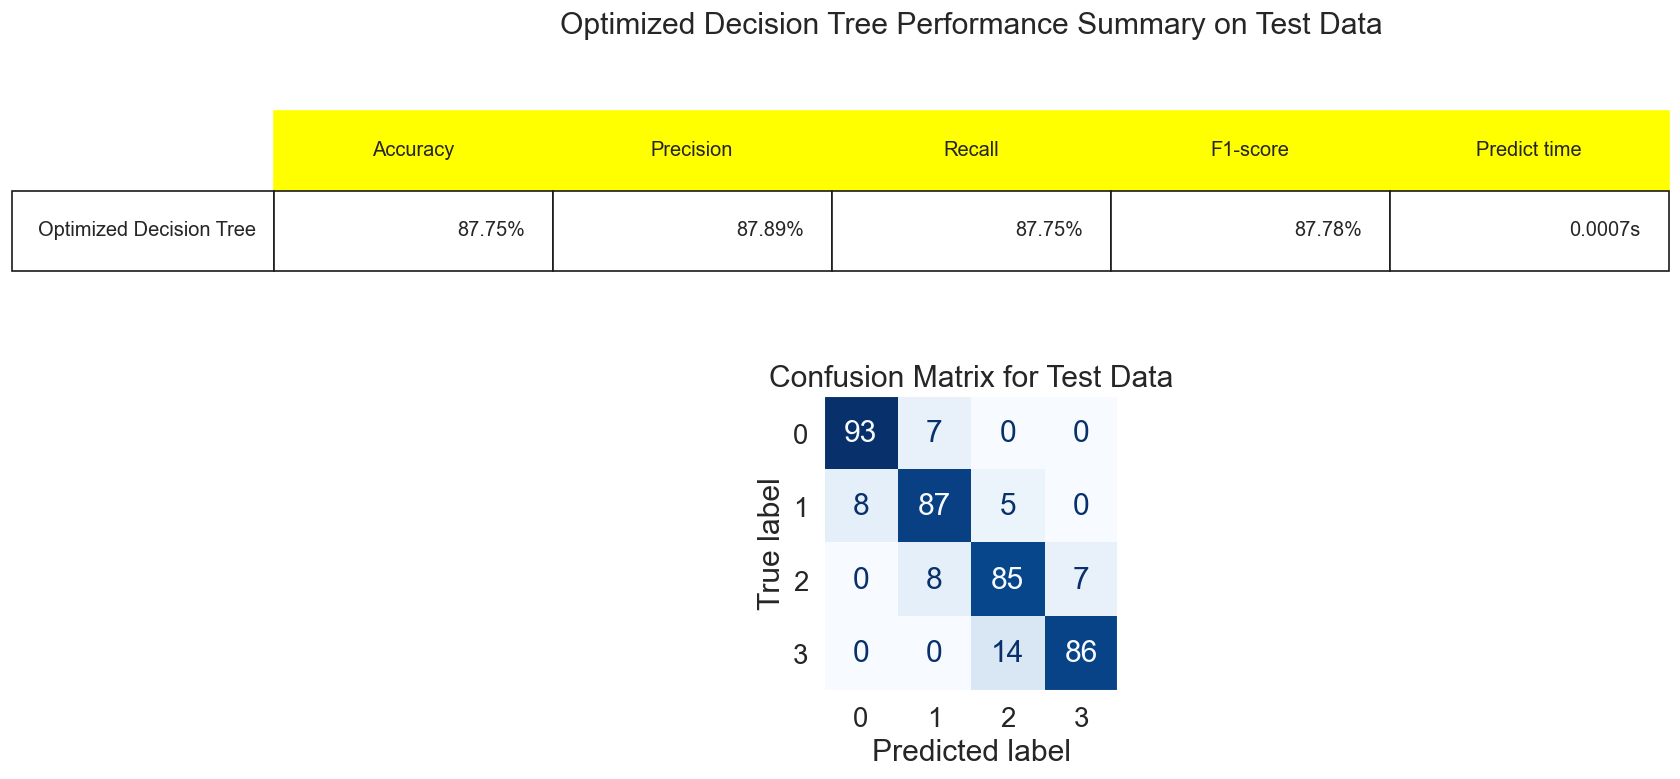

Time taken to make predictions: 0.00 seconds


In [ ]:
# Retrain the dt_optimized model using the updated feature set
dt_optimized.fit(X_train_denoised_droped, y_train)
model_evaluation(dt_optimized, X_train_denoised_droped, X_test_denoised_droped, y_train, y_test, 'Optimized Decision Tree')

## Random Forest
    1. Hyperparameter Tuning with GridSearchCV (cross-validation (5 folds))
    2. Drop unnecessary features
    3. Hyperparameter Tuning again with droped features
    3. Train and apply Decision Tree classifier

#### Hyperparameter Tuning

In [ ]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [70, 100, 120, 150],
    'max_depth': np.arange(10, 18),
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}
# There are 4*2*3*3: 72 considered options

In [ ]:
# Perform train test split
X_train_denoised, X_test_denoised, y_train, y_test = train_test_split(X_denoised, y, test_size=0.2, random_state=0, stratify=y)

# X_train_denoised.head()
# y_train.head()
# Create a random forest classifier object
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
rf_optimised = tune_hyperparameters(rf, param_grid, X_train_denoised, y_train)

Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}, Accuracy: 0.8794
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, Accuracy: 0.8800
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}, Accuracy: 0.8800
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}, Accuracy: 0.8794
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 70}, Accuracy: 0.8800
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}, Accuracy: 0.8825
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 120}, Accuracy: 0.8831
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}, Accuracy: 0.8825
Hyperparameters: {'max_depth': 10,

#### Feature Selection

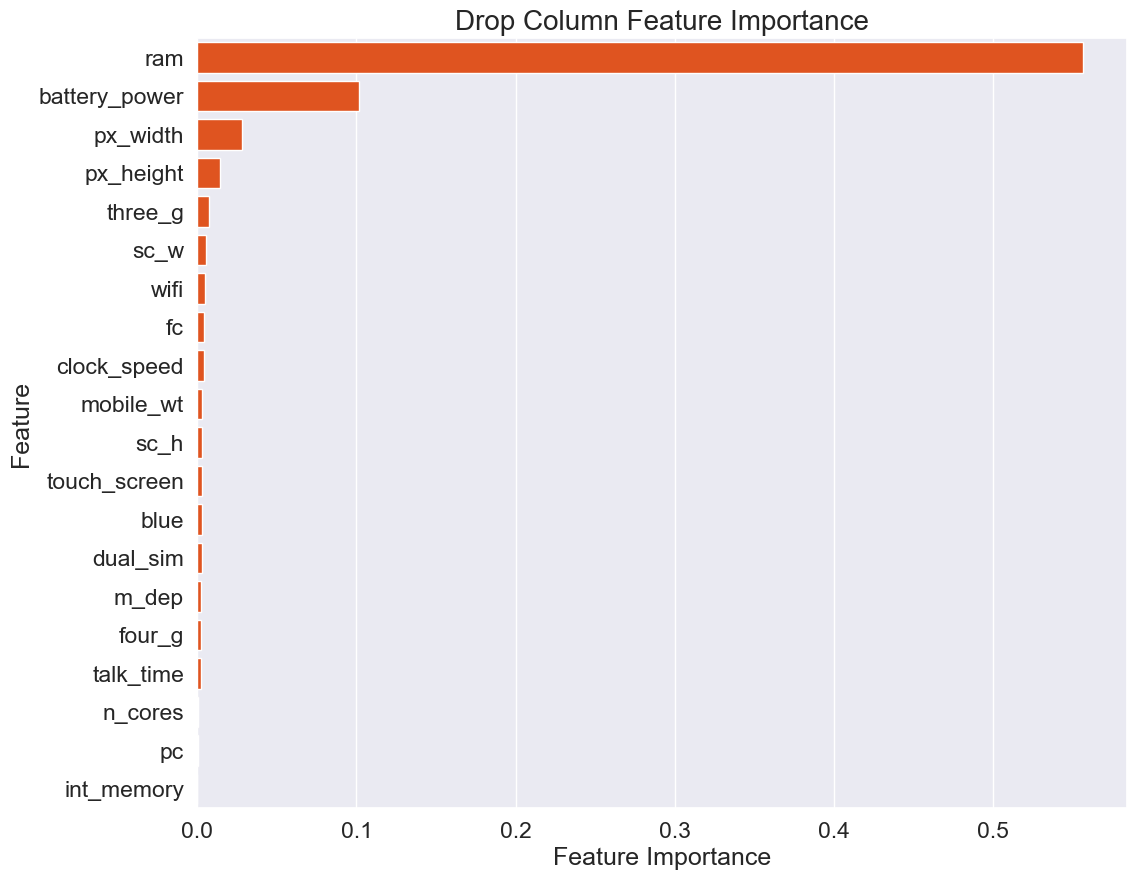

In [ ]:
drop_column_importance_plot(rf_optimised, X_train_denoised, y_train)

In [ ]:
feature_importances_2 = drop_column_importance(rf_optimised, X_train_denoised, y_train, 0)
selected_features_2 = feature_importances[feature_importances['feature importance']>0.01]['feature']  # Threshold value of 0.01

# Filter dataset
X_train_denoised_droped_2 = X_train_denoised[selected_features_2]
X_test_denoised_droped_2 = X_test_denoised[selected_features_2]

pd.DataFrame(selected_features_2)

,feature
0,ram
1,battery_power
2,px_width
3,px_height


#### Implementation


Execute Hyperparameter Tunning again because we dropt unnecessary features

In [ ]:
# Create a random forest classifier object
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
rf_optimised = tune_hyperparameters(rf, param_grid, X_train_denoised_droped_2, y_train)

Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}, Accuracy: 0.8925
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, Accuracy: 0.8944
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}, Accuracy: 0.8906
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}, Accuracy: 0.8906
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 70}, Accuracy: 0.8931
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}, Accuracy: 0.8938
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 120}, Accuracy: 0.8925
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}, Accuracy: 0.8919
Hyperparameters: {'max_depth': 10,

#### Non-Optimized Random forest


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       100
           1       0.88      0.92      0.90       100
           2       0.82      0.80      0.81       100
           3       0.88      0.88      0.88       100

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89 

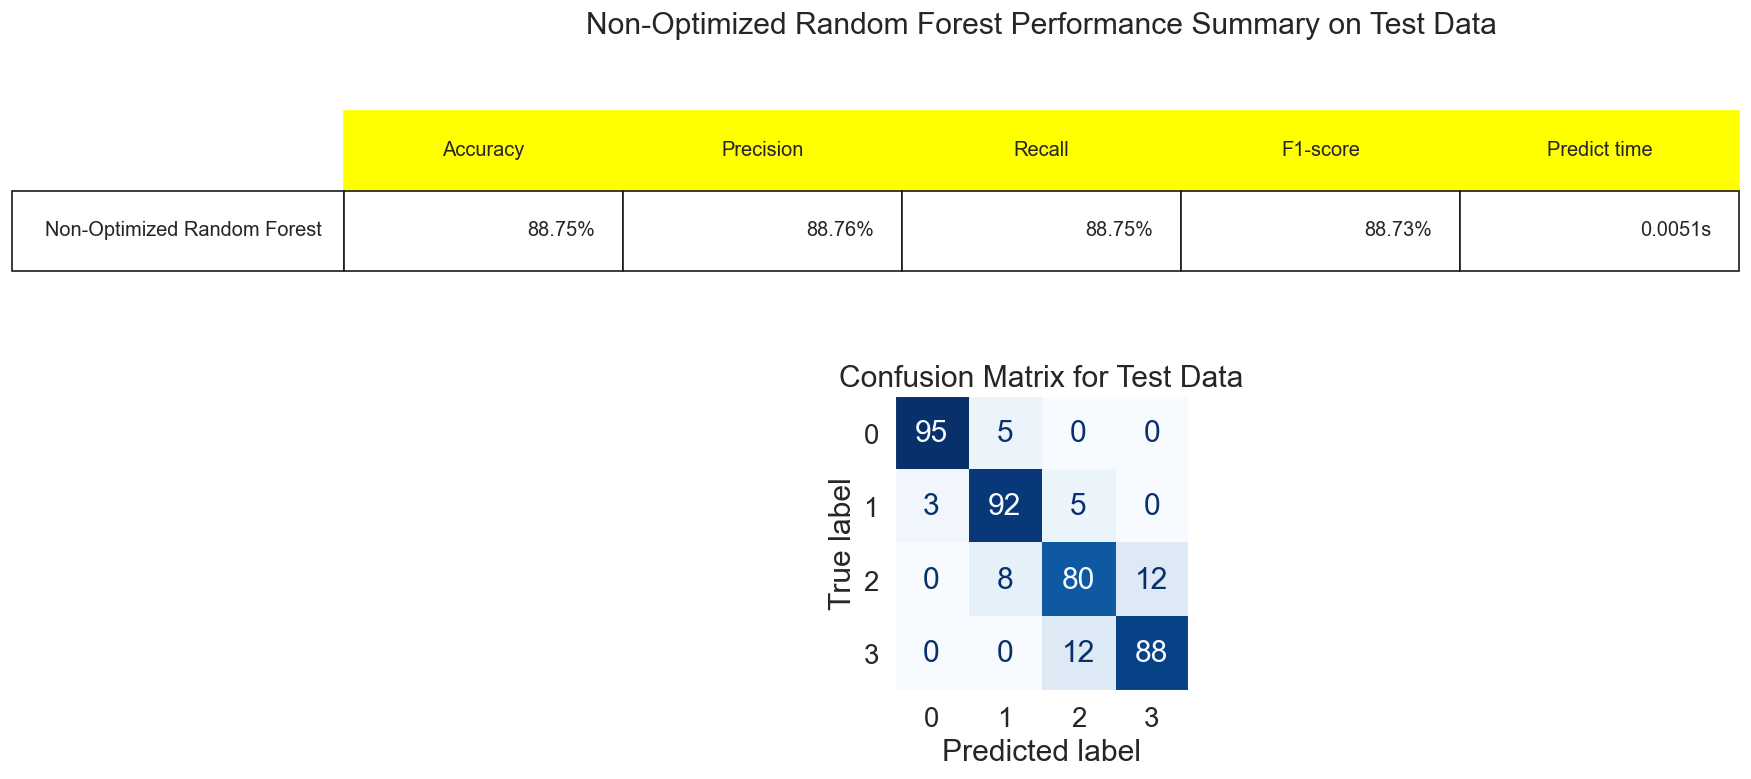

Time taken to make predictions: 0.01 seconds


In [ ]:
rf.fit(X_train, y_train)
model_evaluation(rf, X_train, X_test, y_train, y_test, 'Non-Optimized Random Forest')

#### Optimized Random forest


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       100
           1       0.91      0.91      0.91       100
           2       0.84      0.87      0.85       100
           3       0.93      0.89      0.91       100

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91 

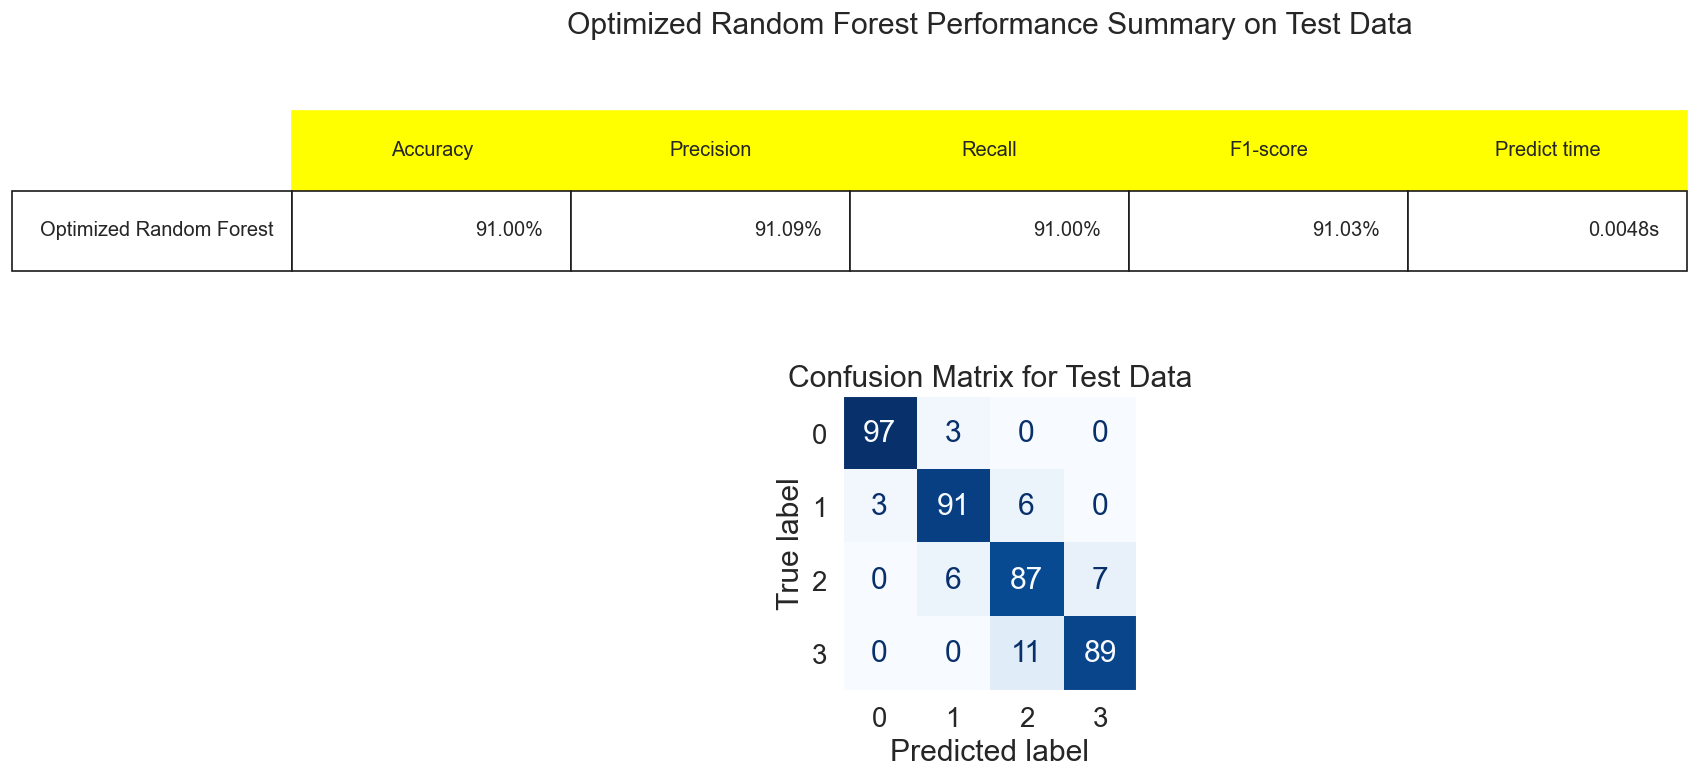

Time taken to make predictions: 0.00 seconds


In [ ]:
rf_optimised.fit(X_train_denoised_droped_2, y_train)
model_evaluation(rf_optimised, X_train_denoised_droped_2, X_test_denoised_droped_2, y_train, y_test, 'Optimized Random Forest')

# Metrics

In [ ]:
# Save the final performance of Random Forest classifier
rf_result = metrics_calculator(rf_optimised, X_test_denoised_droped, y_test, 'Random Forest')

In [ ]:
# Save the final performance of Decision Tree classifier
dt_result = metrics_calculator(dt_optimized, X_test_denoised_droped_2, y_test, 'Decision Tree')

In [ ]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([svm_result, dt_result, rf_result], axis=0).T


# # Sort the dataframe in descending order based on accuracy
results.loc['Accuracy'] = results.loc['Accuracy'].str.replace('%', '').astype(float)
results = results.T.sort_values(by='Accuracy', ascending=False)
results['Accuracy'] = results['Accuracy'].astype(str) + '%'
results

# # Color the accuracy column
results.style.map(lambda x: 'background-color: Red', subset='Accuracy')

,Accuracy,Precision,Recall,F1-score,Predict time
SVM,97.25%,97.26%,97.25%,97.25%,0.0145s
Random Forest,91.0%,91.09%,91.00%,91.03%,0.0215s
Decision Tree,87.75%,87.89%,87.75%,87.78%,0.0016s


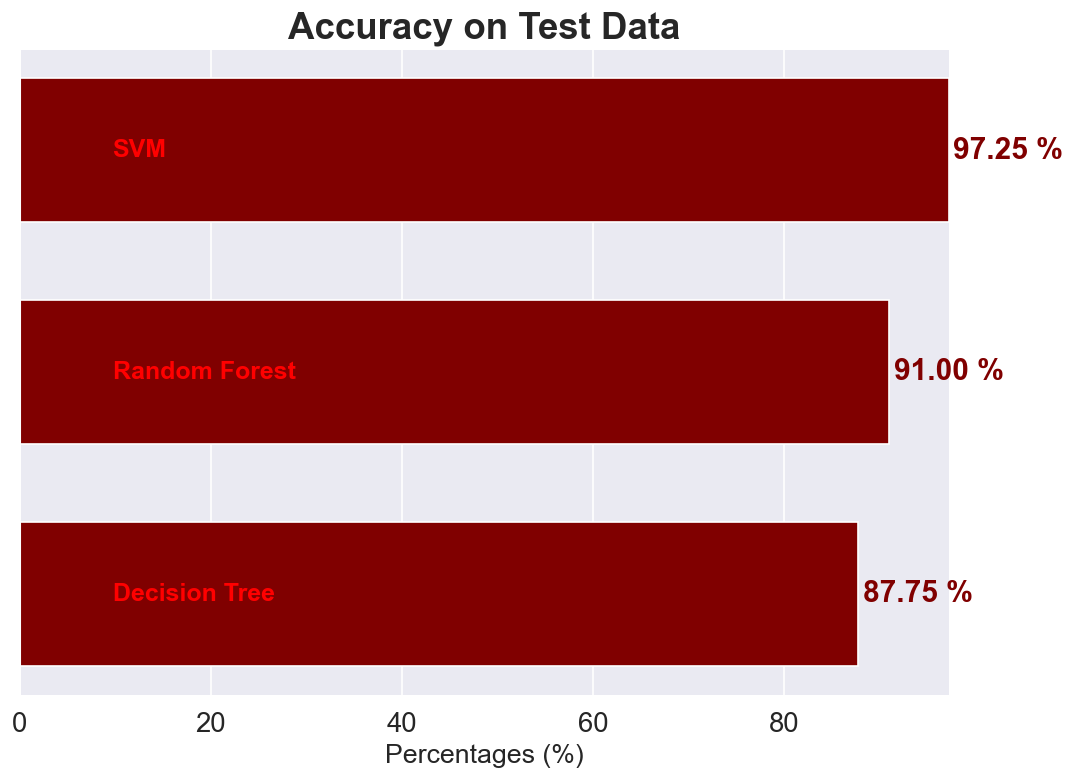

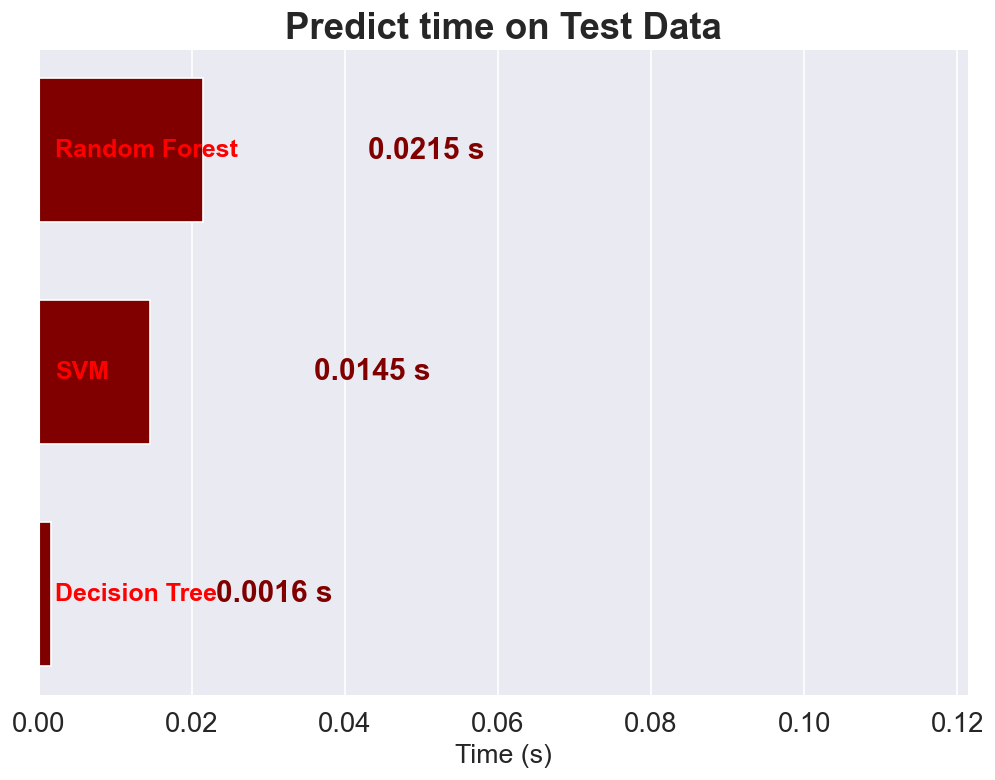

In [ ]:
def plot_compare_metrics(metric):
    # Prepare values
    results.sort_values(by=metric, ascending=True, inplace=True)

    if metric in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
        result = results[metric].str.strip('%').astype(float)
    elif metric == 'Predict time':
        result = results[metric].str.strip('s').astype(float)

    # Plot the barh chart
    fig, ax = plt.subplots(figsize=(10, 7), dpi=120)
    ax.barh(results.index, result, color='maroon', height=0.65)

    # Annotate the values and indexes
    for i, (value, name) in enumerate(zip(result, results.index)):
        if metric in ['Accuracy', 'F1-score', 'Precision', 'Recall']:
            ax.text(value + 0.5, i, f"{value:.2f} %", ha='left', va='center', fontweight='bold', color='maroon', fontsize=18)
        else:
            ax.text(value +result.max(), i, f"{value:.4f} s", ha='left', va='center', fontweight='bold', color='maroon', fontsize=18)

        ax.text(result.max() / 10, i, name, ha='left', va='center', fontweight='bold', color='red', fontsize=15)

    # Remove yticks
    ax.set_yticks([])

    # Set x-axis limit
    ax.set_xlim([0, result.max()+0.1])

    # Add title and xlabel
    plt.title(metric + " on Test Data", fontweight='bold', fontsize=22)
    if metric in ['Accuracy', 'F1-score', 'Precision', 'Recall']:
        plt.xlabel('Percentages (%)', fontsize=16)
    else:
        plt.xlabel('Time (s)', fontsize=16)
    plt.show()


plot_compare_metrics('Accuracy')
plot_compare_metrics('Predict time')

In [ ]:
# Define the features (X) and the output labels (y) of the given dataset:
X = data.drop('price_range', axis=1)
y = data['price_range']

# Create a pipeline to scale the data and train an SVM classifier using obtained optimal hyperparameters
svm_pipeline = Pipeline([
                         ('scaler', StandardScaler()),
                         ('svm', SVC(probability=True, C=50, kernel='linear', random_state=0))
                        ])

# Train the SVM classifier on the whole dataset
svm_pipeline.fit(X, y)

# Read samples
data_samples = pd.read_csv('./dataset/test.csv')

# Remove id column
data_samples.drop('id', axis=1, inplace=True)

# Predict samples class
data_samples['price_range_pred'] = svm_pipeline.predict(data_samples)
data_samples['price_range_pred']

0      3
1      3
2      2
3      3
4      1
      ..
995    2
996    1
997    0
998    2
999    2
Name: price_range_pred, Length: 1000, dtype: int64